In [1]:
import os
import sys
print(os.getcwd())
sys.path.append("../WanPy")

import numpy as np
from pythtb import *
from wpythtb import *
from models import *
import matplotlib.pyplot as plt
from functools import partial

%load_ext line_profiler
%timeit

/Users/treycole/Repos/WanPy/dev


In [2]:
def get_periodic_H(model, H_flat, k_vals):
    orb_vecs = model.get_orb_vecs()
    orb_vec_diff = orb_vecs[:, None, :] - orb_vecs[None, :, :]
    # orb_phase = np.exp(1j * 2 * np.pi * np.einsum('ijm, ...m->...ij', orb_vec_diff, k_vals))
    orb_phase = np.exp(1j * 2 * np.pi * np.matmul(orb_vec_diff, k_vals.T)).transpose(2,0,1)

    if model._nspin == 2:
        orb_phase = orb_phase[:, :, np.newaxis, :, np.newaxis]
        
    H_per_flat = H_flat * orb_phase
    return H_per_flat


def vel_fd(H_k, mu, dk_mu, order_eps, mode='central'):
    coeffs, stencil = finite_diff_coeffs(order_eps=order_eps, mode=mode)

    fd_sum = np.zeros_like(H_k)

    for s, c in zip(stencil, coeffs):
        fd_sum += c * np.roll(H_k, shift=-s, axis=mu)

    v = fd_sum / (dk_mu)
    return v


def berry_curvature(v_k, H_flat, occ_idxs=None):
    evals, evecs = np.linalg.eigh(H_flat)  # (..., n_state), (..., n_state, n_state)
    evecs = evecs.swapaxes(-1, -2)  # swap for consistent indexing
    
    n_eigs = evals.shape[-1]

    # Identify occupied bands
    if occ_idxs is None:
        occ_idxs =  np.arange(n_eigs//2)
    elif occ_idxs == 'all':
        occ_idxs =  np.arange(n_eigs)
    else:
        occ_idxs = np.array(occ_idxs)

    # Identify conduction bands
    cond_idxs = np.setdiff1d(np.arange(n_eigs), occ_idxs)  # Identify conduction bands

    # Compute energy denominators in vectorized way
    delta_E = evals[..., np.newaxis, :] - evals[..., :, np.newaxis]
    with np.errstate(divide="ignore", invalid="ignore"):  # Suppress warnings
        inv_delta_E = np.where(delta_E != 0, 1 / delta_E, 0)

    # Rotate velocity operators to eigenbasis
    evecs_conj = evecs.conj()[np.newaxis, ...]
    evecs_T =  np.swapaxes(evecs, -1, -2)[ np.newaxis, ...]
    v_k_rot = np.matmul(evecs_conj, np.matmul(v_k, evecs_T)) # (dim_k, n_kpts, n_orb, n_orb)

    # Extract relevant submatrices
    v_occ_cond = v_k_rot[..., occ_idxs, :][..., :, cond_idxs]
    v_cond_occ = v_k_rot[..., cond_idxs, :][..., :, occ_idxs]
    delta_E_occ_cond = inv_delta_E[..., occ_idxs, :][..., :, cond_idxs]

    v_occ_cond = v_occ_cond * delta_E_occ_cond
    v_cond_occ = v_cond_occ * delta_E_occ_cond.swapaxes(-1,-2)

    # Initialize Berry curvature
    b_curv = 1j * ( 
        np.matmul(v_occ_cond[:, None], v_cond_occ[None, :]) 
        - np.matmul(v_occ_cond[None, :], v_cond_occ[:, None])
    )

    return b_curv

In [5]:
t = 0  # spin-independent first-neighbor hop
soc = 0  # spin-dependent second-neighbor hop
m = 0 # magnetic field magnitude
beta = 0
fkm_model = fu_kane_mele(t, soc, m, beta)

recip_lat_vecs = fkm_model.get_recip_lat_vecs()
n_spin = fkm_model.n_spin
n_orb = fkm_model.n_orb
n_states = n_spin * n_orb
n_occ = n_states//2

nks = 24, 24, 24
n_beta = 80
k_mesh = K_mesh(fkm_model, *nks)
k_flat = k_mesh.flat_mesh
n_param = nks + (n_beta,)
max_beta = 2*np.pi
betas = np.linspace(0, max_beta, n_beta, endpoint=False) # change to endpoint=False for periodic

fixed_params = {"t": 1, "soc": 1/4, "m": 1/2}
lambda_vals = {"beta": betas}
model_gen = partial(fu_kane_mele, **fixed_params)

# bloch_states = Bloch(fkm_model, *n_param)
# bloch_states.solve_model(model_fxn=model_gen, lambda_vals=lambda_vals)
# bloch_states.set_pbc_lam()
# u_wfs = bloch_states.get_states()["Cell periodic"]

print("Total number of parameter points: ", np.prod(n_param))
# print(f"Max beta = {max_beta} \nBloch periodic? {bloch_states.pbc_lam}")
print(f"Number of orbs: {n_spin}")
print(f"Number of spins: {n_spin}")
print("Number of states:", n_states)
print("Number of occupied bands:", n_occ)
# print("Shape of wf array:", u_wfs.shape)
# print(bloch_states.get_wf_axes())

Total number of parameter points:  1105920
Number of orbs: 2
Number of spins: 2
Number of states: 4
Number of occupied bands: 2


(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='Energy $E(\\mathbf{{k}})$'>)

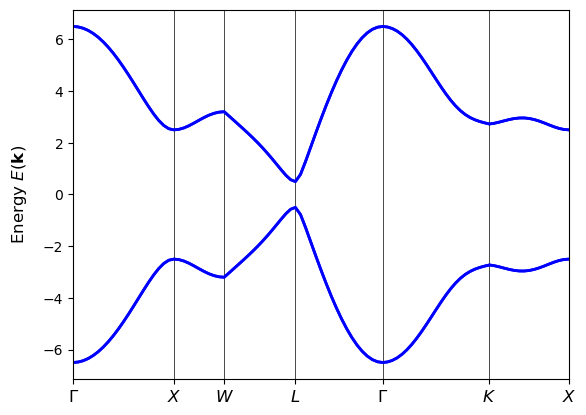

In [6]:
k_path = [
    [0.0,   0.0,   0.0],    # Γ
    [0.5,   0.0,   0.5],    # X
    [0.5,   0.25,  0.75],   # W
    [0.5,   0.5,   0.5],    # L
    [0.0,   0.0,   0.0],    # Γ
    [0.375, 0.375, 0.75],   # K
    [0.5,   0.0,   0.5]     # X
]
k_label = (r'$\Gamma$', r'$X$', r'$W$', r'$L$', r'$\Gamma$', r'$K$', r'$X$')

model_gen(beta=betas[0]).plot_bands(k_path, k_label=k_label)

In [7]:
v_k = np.zeros((fkm_model.dim_k, k_flat.shape[0], n_beta, n_states, n_states), dtype=complex)
H_kbeta = np.zeros((k_flat.shape[0], n_beta, n_states, n_states), dtype=complex)

for idx, beta in enumerate(betas):
    print(idx)
    fkm_model_fxd = model_gen(beta=beta)
    H = fkm_model_fxd.get_ham(k_flat)
    v = fkm_model_fxd.gen_velocity(k_flat)

    # flatten spin
    new_shape = (H.shape[0],) + (n_spin*n_orb, n_spin*n_orb)
    H = H.reshape(*new_shape) 
    new_shape = (v.shape[:2]) + (n_spin*n_orb, n_spin*n_orb)
    v = v.reshape(*new_shape)
    
    H_kbeta[:, idx, ...] = H
    v_k[:, :, idx, ...] = v

print(H_kbeta.shape)
print(v_k.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
(13824, 80, 4, 4)
(3, 13824, 80, 4, 4)


In [8]:
d_beta = max_beta/n_beta  # Step size for beta integration
v_beta = vel_fd(H_kbeta, 1, d_beta, 12)
v_beta = v_beta[np.newaxis, ...]

In [9]:
v = np.concatenate((v_k, v_beta), axis=0)
b_curv = berry_curvature(v, H_kbeta)

In [10]:
dim_k = 3  # Number of k-space dimensions
dim_lam = 1  # Number of adiabatic dimensions
dim_total = 4

# Construct delta_k with 4D embedding (extra zeros for adiabatic params)
delta_k = np.zeros((dim_k, dim_total))  # (3, dim_total)
delta_k[:, :dim_k] = recip_lat_vecs / np.array(nks)[:, None]
# Construct delta_lambda (embedding into 4D with zeros in k-space parts)
delta_lam = np.zeros((dim_lam, dim_total))  # (dim_lam, dim_total)
np.fill_diagonal(delta_lam[:, dim_k:], max_beta / np.array(n_beta))

dk = np.vstack([delta_k, delta_lam])  # (dim_total, dim_total)
d4k = np.linalg.det(dk)

print("dk vectors: \n",dk)
print("det(dk) =", d4k)

dk vectors: 
 [[-0.13089969  0.13089969  0.13089969  0.        ]
 [ 0.13089969 -0.13089969  0.13089969  0.        ]
 [ 0.13089969  0.13089969 -0.13089969  0.        ]
 [ 0.          0.          0.          0.07853982]]
det(dk) = 0.000704637521947356


In [11]:
recip_basis = recip_lat_vecs/ np.linalg.norm(recip_lat_vecs, axis=1, keepdims=True)
g = recip_basis @ recip_basis.T
sqrt_mtrc = np.sqrt(np.linalg.det(g))

delta_k = np.array([recip_lat_vecs[k_idx]/(nk) for k_idx, nk in enumerate(nks)]) 
dk1 = np.linalg.norm(recip_lat_vecs[0]/(nks[0]))
dk2 = np.linalg.norm(recip_lat_vecs[1]/(nks[1]))
dk3 = np.linalg.norm(recip_lat_vecs[2]/(nks[2]))
d_beta = max_beta/n_beta  # Step size for beta integration

d3k = np.linalg.det(delta_k)
d4k, d2ks = compute_d4k_and_d2k(dk) 
d3k_alt = np.prod([dk1, dk2, dk3])
d4k_alt = np.prod([dk1, dk2, dk3, d_beta])

print(dk1, dk2, dk3, d_beta)
print(sqrt_mtrc)
print(d3k_alt, d4k_alt)
print(d3k_alt*sqrt_mtrc, d4k_alt*sqrt_mtrc)
print(d3k, d4k)
print(fkm_model.get_recip_vol()/np.prod(nks))

0.2267249205292772 0.2267249205292772 0.2267249205292772 0.07853981633974483
0.7698003589195012
0.011654610799439524 0.0009153509916991869
0.00897172357647564 0.0007046375219473554
0.008971723576475646 0.000704637521947356
0.008971723576475639


In [12]:
epsilon = levi_civita(4, 4)
chern2_density = np.einsum("ijkl, ij...mn, kl...nm->...", epsilon, b_curv, b_curv)

In [13]:
chern2 = np.sum(chern2_density) * d4k / (32 * np.pi**2)
print("C2 =", chern2.real)

C2 = 1.00951966382514


In [14]:
thetas = np.zeros(betas.shape[0], dtype=complex)

for beta_idx, beta in enumerate(betas):
    sliced_dtheta = chern2_density[..., :beta_idx+1]

    theta = np.sum(sliced_dtheta) * d4k #/sqrt_mtrc
    
    thetas[beta_idx] = theta / (16 * np.pi)

In [15]:
c2 = np.sum(chern2_density, axis=0) * d3k
thetas = np.cumsum(c2) * d_beta / (16 * np.pi)

Text(0.5, 1.0, 'Kubo formula\nDerivative along $k$, Finite Difference along $\\beta$')

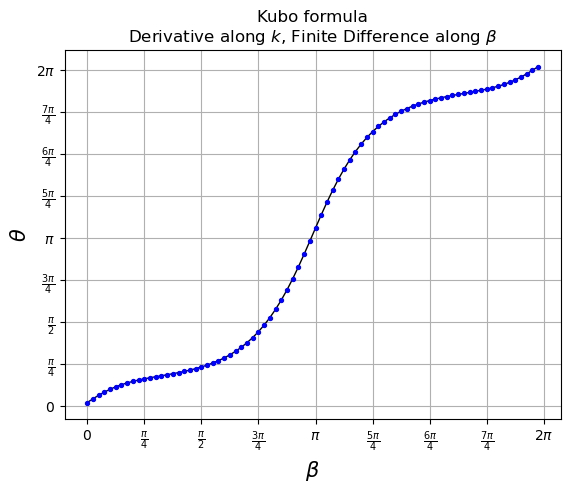

In [16]:
#### Plotting theta(beta)

fig, ax = plt.subplots()

ax.set_xlabel(r"$\beta$", size=15)
ax.set_ylabel(r"$\theta$", size=15)

tick_positions = np.arange(0, 2*np.pi+np.pi/4, np.pi/4)
tick_labels = [
    r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$", 
    r"$\frac{5\pi}{4}$", r"$\frac{6\pi}{4}$", r"$\frac{7\pi}{4}$", r"$2\pi$"]

# Set the ticks and labels for both axes
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)

# ax.set_ylim(0, np.pi+.02)
# ax.set_xlim(0, np.pi+0.02)

ax.plot(betas, thetas.real, lw=1, zorder=2, c='k')  
ax.scatter(betas, thetas.real, s=8, zorder=2, c='b')
ax.grid()
ax.set_title("Kubo formula\n"+ r"Derivative along $k$, Finite Difference along $\beta$")